# RehabML - A Machine Learning Approach to Find Socio-Economic Factors That Lead to Drug Rehab Patients Leaving Treatment Prematurely

This project focuses on creating some sort of prediction algorithm that can identify at-risk drug rehabilitation patients who will leave the program before they are healed. The dataset is from the Substance Abuse and Mental Health data archive and it has the discharge of every publicly funded rehab center in the United States. It can be downloaded (stata version is what I used and then converted to a csv file) on this website: https://www.datafiles.samhsa.gov/study-dataset/teds-d-2017-ds0001-teds-d-2017-ds0001-nid18480

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#imports necessary modules for data collection and classification

In [2]:
df = pd.read_csv('drug_users.csv') #reads csv file into pandas dataframe

Specifically, I am looking at the REASON column in which there are 7 numbers (1-7) which keep track of the nature the patient discharged. The number 2 represents the patient dropping out early voluntarily without being fully healed. Other reasons are listed on page 37 of http://samhda.s3-us-gov-west-1.amazonaws.com/s3fs-public/field-uploads-protected/studies/TEDS-D-2017/TEDS-D-2017-datasets/TEDS-D-2017-DS0001/TEDS-D-2017-DS0001-info/TEDS-D-2017-DS0001-info-codebook.pdf

Specifically for this project, I will define reason 2 as voluntarily leaving and the others as not voluntarily leaving.

In [3]:
df['REASON'].value_counts()

1.0    679850
2.0    425444
4.0    363591
3.0     99319
7.0     59565
5.0     29650
6.0      3788
Name: REASON, dtype: int64

We can see the counts of the values of REASONS. Since we are only focused on reason 2 versus everyone else, it makes sense to make this a binary classification problem, with 1,3,4,5,6,7 being 0 and 2 being 1. The code below does just that.

In [5]:
for i in range(7):
    if i != 1:
        df['REASON'] = np.where(df['REASON'].astype(int) == i + 1, 0, df['REASON'])
        
df['REASON'] = np.where(df['REASON'].astype(int) == 2, 1, df['REASON'])
        
df['REASON'].value_counts() #should only have two value counts

0.0    1235763
1.0     425444
Name: REASON, dtype: int64

The data is clearly imbalanced, so we will implement a SMOTE algorithm(Synthetic Minority Oversampling Technique).

In [10]:
! pip install imbalanced-learn --user

In [11]:
from imblearn.over_sampling import SMOTE

In [18]:
X = df.loc[:, df.columns != 'REASON']
y = df.loc[:, df.columns == 'REASON']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #splits data set into testing and training
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not voluntarily leaving in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of voluntarily leaving",len(os_data_y[os_data_y['y']==1]))
print("Proportion of not voluntarily leaving in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of voluntarily leaving in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  1730230
Number of not voluntarily leaving in oversampled data 865115
Number of voluntarily leaving 865115
Proportion of not voluntarily leaving in oversampled data is  0.5
Proportion of voluntarily leaving in oversampled data is  0.5


To find the features that is best performing, I am going to use Recursive Feature Elimination (RFE), which repeatedly constructs a model to find high performing features and sets them aside.

In [31]:
df_vars=df.columns.values.tolist()

logreg = LogisticRegression(solver = 'lbfgs') #make sure to put solver or else there will be a plethora of warning messages
rfe = RFE(logreg, 40)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)
factors = list(df.columns)
relevant = list()
for i in range(len(df_vars)-1):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] and factors[i] != "REASON":
        relevant.append(factors[i])
        
print(relevant)

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 37.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 17.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 4.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 18.000
Column: 18, Selected False, Rank: 11.000
Column: 19, Selected False, Rank: 8.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected True

We can make a valid assumption that unnamed and caseid don't affect drug rehab patients at all, so we can ignore those. Otherwise,

In [32]:
print("Number of selected factors:", len(relevant) - 2)
print("Selected factors:", relevant[2:])

Number of selected factors: 37
Selected factors: ['STFIPS', 'CBSA2010', 'EDUC', 'SERVICES', 'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'METHUSE', 'PSYPROB', 'PREG', 'DAYWAIT', 'SERVICES_D', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'SUB3', 'SUB1_D', 'SUB2_D', 'ROUTE1', 'FREQ1', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FRSTUSE1', 'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'FREQ_ATND_SELF_HELP', 'OTHERFLG', 'DIVISION', 'REGION']


There RFE helped us selected the following features: ['STFIPS', 'CBSA2010', 'EDUC', 'SERVICES', 'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'METHUSE', 'PSYPROB', 'PREG', 'DAYWAIT', 'SERVICES_D', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'SUB3', 'SUB1_D', 'SUB2_D', 'ROUTE1', 'FREQ1', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FRSTUSE1', 'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'FREQ_ATND_SELF_HELP', 'OTHERFLG', 'DIVISION', 'REGION']

In [40]:
cols = ['STFIPS', 'CBSA2010', 'EDUC', 'SERVICES', 'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'METHUSE', 'PSYPROB', 'PREG', 'DAYWAIT', 'SERVICES_D', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'SUB3', 'SUB1_D', 'SUB2_D', 'ROUTE1', 'FREQ1', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FRSTUSE1', 'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'FREQ_ATND_SELF_HELP', 'OTHERFLG', 'DIVISION', 'REGION']
X = os_data_X[cols]
y = os_data_y['y']

Since I want to get the statistics of the classification, I need to get the statsmodels module.

In [36]:
! pip install statsmodels --user

In [37]:
import statsmodels.api as sm

C:\Users\rohan\Anaconda4\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [41]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.590186
         Iterations 6
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.149       
Dependent Variable:   y                AIC:              2042389.7931
Date:                 2020-07-08 12:23 BIC:              2042847.2524
No. Observations:     1730230          Log-Likelihood:   -1.0212e+06 
Df Model:             36               LL-Null:          -1.1993e+06 
Df Residuals:         1730193          LLR p-value:      0.0000      
Converged:            1.0000           Scale:            1.0000      
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
STFIPS              -0.0105   0.0002  -69.8496 0.0000 -0.0108 -0.0102
CBSA2010        

Most of the p values are smaller than 0.5, except two of them, so we will remove those two and continue.

In [42]:
cols = ['STFIPS', 'CBSA2010', 'EDUC', 'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'METHUSE', 'PSYPROB', 'PREG', 'DAYWAIT', 'SERVICES_D', 'EMPLOY_D', 'ARRESTS_D', 'DSMCRIT', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'SUB3', 'SUB1_D', 'SUB2_D', 'ROUTE1', 'FREQ1', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FRSTUSE1', 'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'FREQ_ATND_SELF_HELP', 'OTHERFLG', 'DIVISION', 'REGION']

X = os_data_X[cols]
y = os_data_y['y']

logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.590187
         Iterations 6
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.149       
Dependent Variable:   y                AIC:              2042387.7479
Date:                 2020-07-08 12:28 BIC:              2042820.4796
No. Observations:     1730230          Log-Likelihood:   -1.0212e+06 
Df Model:             34               LL-Null:          -1.1993e+06 
Df Residuals:         1730195          LLR p-value:      0.0000      
Converged:            1.0000           Scale:            1.0000      
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
STFIPS              -0.0105   0.0002  -69.8646 0.0000 -0.0108 -0.0102
CBSA2010        

In [43]:
#Model fitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)


C:\Users\rohan\Anaconda4\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
#Predicting test results and calculating accuracy
y_pred = logistic_reg.predict(X_test)
print('Accuracy of logistic regression: {:.4f}'.format(logistic_reg.score(X_test, y_test)))


Accuracy of logistic regression: 0.6732


So the logistic regression model is 67.32 percent accurate. To better see how the classifier worked, I am going to make an ROC curve.

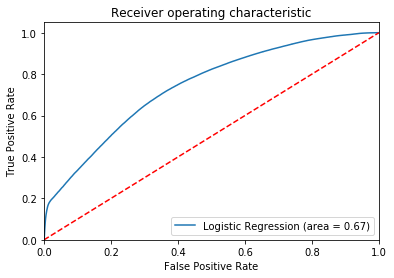

In [52]:
logit_roc_auc = roc_auc_score(y_test, logistic_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

I can't help but think that this could be more accurate. ;)

I believe a better approach would be using a more advanced classifier. For this second simulation, I will be using a Random Tree Classifier.

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
new_clf = RandomForestClassifier(n_estimators = 200) #200 trees

new_clf.fit(X_train, y_train)

new_y_pred = new_clf.predict(X_test)

print("Accuracy of Random Trees: {:.4f}".format(new_clf.score(X_test, y_test)))

Accuracy of Random Trees: 0.8941


Wow! This seems like the better classifier to use. While it is harder to make "equations" for the researchers from this, it has a better predictive factor. BTW the trees part in the output should say forest.

Now to put the Random Forest Classifier in a pickle file for further use.

In [55]:
import pickle

In [56]:
with open('rehab_stopper_randomforest.pkl', 'wb') as file:
    pickle.dump(new_clf, file)